In [1]:
__nbid__ = '0022'
__author__ = 'Felix Pat <felixpat10@email.arizona.edu>'
__version__ = '20240606' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['gogreen_dr1']  # datasets used in this notebook
__keywords__ = ['gemini llp','tap','cluster','photometry','redshift','file service','spectra','catalogues'] # keywords relevant to this notebook

# GOGREEN DR1: Galaxy Cluster Membership
*Author: Felix Pat (Univ. of Arizona), Stéphanie Juneau (NOIRLab), and the Astro Data Lab Team*

### Table of contents
* [Goal](#GGgoal)
* [Summary](#GGsummary)
* [Disclaimer & attribution](#GGdisclaimer)
* [Imports & setup](#GGimport)
* [Reading in catalogs from the Data Lab database](#GG0)
* [Position of all clusters](#GG1)
* [Cluster with the highest dynamical mass](#GG2)
* [Position of galaxies in selected cluster](#GG3)
* [Pick url of selected cluster image](#GG4)
* [Plot image of galaxies in selected cluster](#GG5)
* [References](#GG6)

<a class="anchor" id="GGgoal"></a>
# Goal
This notebook aims to visualize sky positions and redshifts of galaxies as a function of their cluster membership.

<a class="anchor" id="GGsummary"></a>
# Summary
This notebook demonstrates how to generally read data tables, project cluster positions onto a full-sky Mollweide projection, select the cluster with the highest dynamical mass (traced by the velocity dispersion), and plot the galaxy positions color-coded by redshift and separated by cluster membership.

<a class="anchor" id="GGdisclaimer"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="GGimport"></a>
# Imports and setup

In [2]:
# std lib
import re
import operator

# 3rd party
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) # prevent overflow of columns
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams['font.size'] = 14 # increase plots' texts size
from pyvo.dal import sia
from IPython.display import display_html

import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.utils.data import download_file
from astropy.wcs import WCS

# Data Lab
from dl import queryClient as qc, storeClient as sc

In [3]:
# define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) 
# this URL tells the SIA service where to find images and image metadata
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/gogreen_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="GG0"></a>
# Reading in main tables
The full GOGREEN dataset can be found [here](https://datalab.noirlab.edu/gogreendr1/index.php) under the 'Data Access' tab. The first portion of this notebook will rely on information available for all clusters from the 'clusters_table' and information for the galaxies from the 'redshift_table.' Since we do not need all of the photometry/images, we will only retrieve them as needed. 

We can use the `globals()` function to dynamically create variables. [Globals()](https://docs.python.org/3/library/functions.html#globals) returns the dictionary implementing the current module namespace. For code within functions, this is set when the function is defined and remains the same regardless of where the function is called.

In [4]:
dataset = 'gogreen_dr1.'
tables = ['clusters', 'redshift']

for table in tables:
    globals()['%s_table'%table] = qc.query('select * from %s%s' % (dataset, table), fmt = 'pandas')
    print("%s table" %table)
    display_html(globals()[('%s_table'%table)].head(5))

clusters table


,cluster,fullname,cluster_id,ra_best,dec_best,ra_gmos,dec_gmos,pa_deg,redshift,vdisp,vdisp_err,gogreen_m1,gogreen_m2,gogreen_m3,gogreen_m4,gogreen_m5,gogreen_m6,gclass_m1,gclass_m2,gclass_m3,gclass_m4,gclass_m5,kphot_cat,photoz_cat,stelmass_cat,image_u,image_b,image_g,image_v,image_r,image_i,image_z,image_j,image_j1,image_y,image_k,image_irac1,preimage,random_id
0,COSMOS-125,COSMOS-125,14,150.6208,2.1675,150.62720,2.159200,270.0,1.4040,NaN,400,GS2015ALP001-02,GS2016ALP001-02,GS2019ALP001-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
1,COSMOS-221,COSMOS-221,14,150.5620,2.5031,150.57020,2.498600,90.0,1.1960,200.0,50,GS2014BLP001-05,GS2015ALP001-01,GS2016ALP001-01,GS2019ALP001-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-221_pseudo,16.224028
2,COSMOS-28,COSMOS-28,14,149.4692,1.6685,149.45930,1.675030,78.0,1.3160,285.0,75,GN2015BLP004-03,GN2019ALP004-01,GN2019ALP004-02,GN2019ALP004-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-28_pseud,14.708872
3,COSMOS-63,COSMOS-63,14,150.3590,1.9352,150.36147,1.928342,165.0,1.1722,NaN,70,GN2015BLP004-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UVISTA_final_v4.1_t1.fits,UVISTA_final_v4.1_zout.fits,UVISTA_final_colors_sfrs_v4.1.dat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-63_pseudo,10.737590
4,SPT0205,SPT-CL J0205-5829,1,31.4510,-58.4803,31.43896,-58.482900,90.0,1.3227,678.0,57,GS2014BLP001-06,GS2016BLP001-09,GS2016BLP001-02,GS2017BLP001-03,GS2017BLP001-04,GS2017BDD010-01,NaN,NaN,NaN,NaN,NaN,SPTCL-0205_totalall_FOURSTARKs.cat,SPTCL-0205_totalall_Ks.zout,SPTCL-0205_totalall_Ks.fout,mos_VIMOSU_3,mos_VIMOSB_3,NaN,mos_VIMOSV_3,mos_VIMOSR_3,mos_VIMOSI_3,mos_VIMOSz_3,mos_FOURSTARJ_3,mos_FOURSTARJ1_3,NaN,mos_FOURSTARKs_3,mos_IRAC1_3,mfrgS20140928S0161_add,73.878470


redshift table


,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id
0,COSMOS-125,114080478,150.60518,2.118631,1,1.41478,2,1,0,2.855579,1.827386,NaN,NaN,NaN,NaN,NaN,NaN,4.155094,1.096318,0.0,0.0,3.228765,0.796476,7.636033,-1,-1,-1,3709735,378796,111644063,59.368240
1,COSMOS-125,114080570,150.59448,2.120006,1,1.34553,4,2,0,3.217247,2.300130,1.364112,0.076498,11.551618,4.967136,5.405303,4.758426,11.549834,1.890590,0.0,0.0,4.880185,0.753583,71.387190,-1,-1,-1,3709735,378796,111644063,63.859104
2,COSMOS-125,114081196,150.58768,2.128183,3,0.96172,4,3,0,10.048548,7.505558,1.206696,0.030443,3.372206,1.760464,3.249191,1.707648,4.091792,0.768290,0.0,0.0,3.261066,0.575365,25.215458,-1,-1,-1,3709735,378796,111644085,28.451246
3,COSMOS-125,114081258,150.59691,2.129453,1,0.72447,3,4,0,4.754746,3.284939,1.433353,0.130532,1.186794,38.480305,-1.591362,6.184247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,3709735,378796,111644085,75.506805
4,COSMOS-125,114081508,150.60970,2.134149,1,1.13177,4,5,0,2.862871,1.829309,1.294710,0.089390,67.153460,35.867435,2.344702,5.377402,42.830364,3.741641,0.0,0.0,5.096052,0.379176,297.244870,-1,-1,-1,3709735,378796,111644106,52.536415


<a class="anchor" id="GG1"></a>
# Position of GOGREEN clusters on the full sky
First, we need to plot the positions (RA, DEC) in the clusters_table. The projection used is Mollweide, which is an ["equal-area, pseudocylindrical map projection"](https://en.wikipedia.org/wiki/Mollweide_projection).

In [7]:
def allclusters_mollweide(clusters_table, ax, cluster_of_interest=None):
    """
    Retrieve the positions (RA, DEC) of clusters in dataset to plot them on a mollweide projection.

    Parameters
    ----------
    clusters_table : pandas dataframe
    Data table for all clusters

    ax : class matplotlib.axes.Axes
    Plots the data
    
    cluster_of_interest : pandas series as bool
    Used as an index for pulling specific row(s) for selected cluster

    Returns
    -------
    None
    """    
    # set RA and DEC to units of degrees
    clusters_table.ra_best = clusters_table.ra_best - 180 #set RA range to (-180, 180)
    #ra = coord.Angle(clusters_table['ra_best']*u.degree)
    ra = coord.Angle(clusters_table['ra_best'].values*u.degree)
    ra = ra.wrap_at(180*u.degree) # make the plot 'continuous' at 180 degrees
    #dec = coord.Angle(clusters_table['dec_best']*u.degree)
    dec = coord.Angle(clusters_table['dec_best'].values*u.degree)
    
    #plot the position projection
    ln = ax.scatter(ra.radian, dec.radian,c=clusters_table.redshift, lw=0, cmap='turbo')
    fig.colorbar(ln, fraction=.02, pad=0.04, label='redshift')
    if cluster_of_interest is not None:
        ra = coord.Angle(clusters_table.ra_best[cluster_of_interest]*u.degree)
        ra = ra.wrap_at(180*u.degree)
        dec = coord.Angle(clusters_table.dec_best[cluster_of_interest]*u.degree)
        ax.scatter(ra.radian, dec.radian, s=150, facecolors='black', marker=(5, 1))# plot a star symbol at the cluster of interest position
    plt.title("Position of GOGREEN Galaxy Clusters Color-Coded by Redshift")
    plt.xlabel("RA (deg)")
    plt.ylabel("DEC (deg)")
    plt.grid(True)
    ax.set_aspect(0.5) #set proportion of plot to scale of axes
    plt.show()
    clusters_table.ra_best = clusters_table.ra_best + 180 #reset RA values
    
    # print number of clusters for information
    print(' ')
    print(f'There are {len(clusters_table)} galaxy clusters on the panel.')

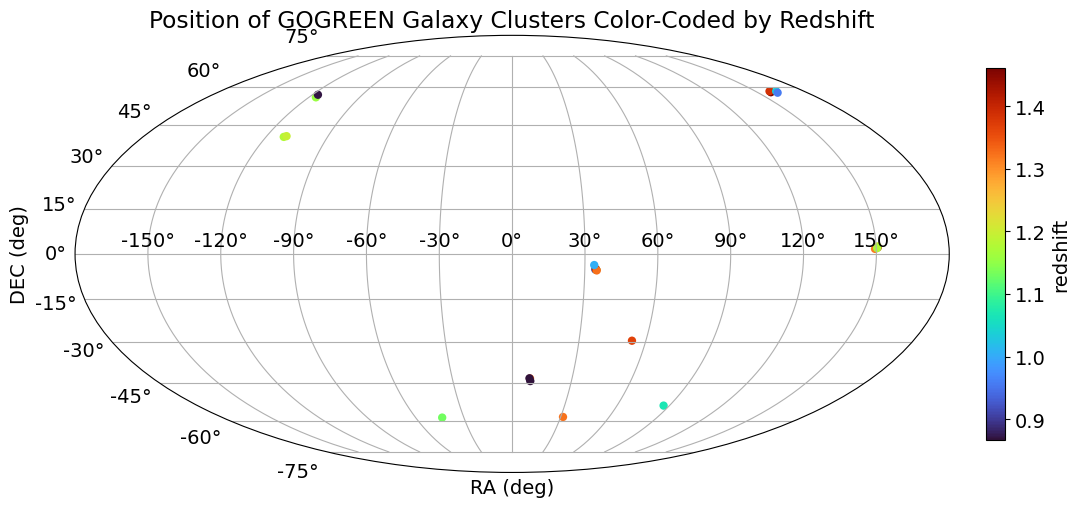

 
There are 26 galaxy clusters on the panel.


In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
allclusters_mollweide(clusters_table, ax);

There are 26 galaxy clusters in this dataset, and they sometimes appear as distributed closely on the sky. However, the redshift colorbar indicates this 2D projection is not necessarily indicative to how close the clusters are to each other in space.

<a class="anchor" id="GG2"></a>
# Select cluster with the highest dynamical mass
In this example, the galaxy cluster with the highest velocity dispersion (`vdisp`) is selected as a proxy for the cluster with the highest dynamical mass. In astronomy, the [velocity dispersion (σ)](https://en.wikipedia.org/wiki/Velocity_dispersion) is the statistical dispersion of velocities about the mean velocity for a group of astronomical objects, such as an open cluster, globular cluster, galaxy, galaxy cluster, or supercluster. By measuring the radial velocities of the group's members through astronomical spectroscopy, the velocity dispersion of that group can be estimated and used to derive the group's mass from the virial theorem. 

The black star indicates the position of the selected cluster. In subsequent plots, the black star represents the mean position of all galaxies identified as a member of the cluster.

In [9]:
def select_cluster(clusters_table):
    """
    Returns pandas series as bool, index, and name of selected cluster.

    Parameters
    ----------
    clusters_table : pandas dataframe
    Data table for all clusters

    Returns
    -------
    cluster_of_interest : pandas series as bool
    Used as an index for pulling specific row(s) for selected cluster
    
    index_num : int
    Index of selected cluster
    
    select_name : string
    Name of selected cluster
    """
    # select the cluster with the highest velocity dispersion
    cluster_of_interest = clusters_table.vdisp == np.nanmax(clusters_table.vdisp)
    for i in range(len(cluster_of_interest)):
        if cluster_of_interest[i]==True:
            print("index =", i)
            index_num = i
    select_ra = clusters_table.ra_best[index_num]
    select_dec = clusters_table.dec_best[index_num]
    select_name = clusters_table.cluster[index_num]
    print("RA = %f, DEC = %f" %(select_ra, select_dec))
    print(select_name)
    
    return (cluster_of_interest, index_num, select_name)

In [10]:
cluster_of_interest, index_num, selection = select_cluster(clusters_table)

index = 25
RA = 63.311000, DEC = 56.825000
SpARCS1613


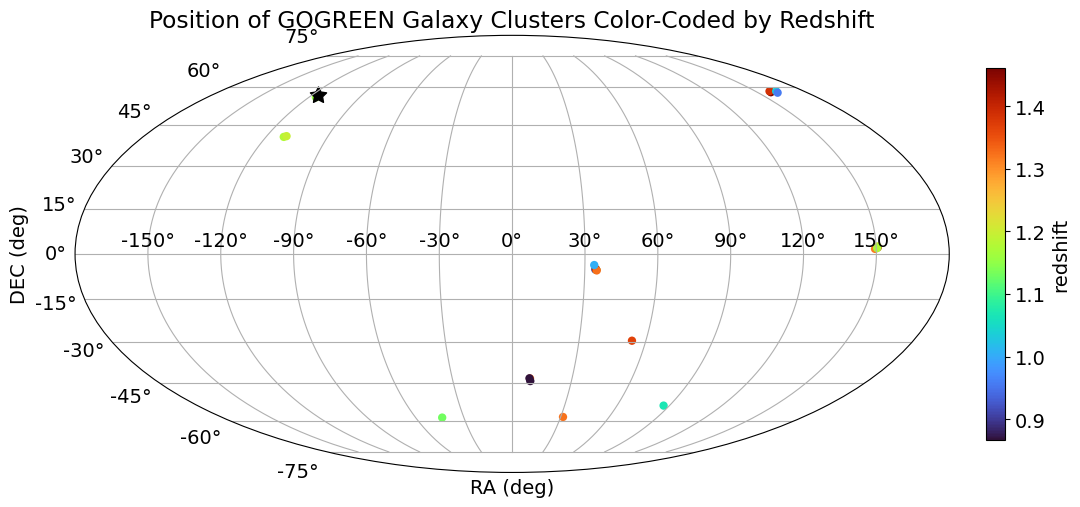

 
There are 26 galaxy clusters on the panel.


In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="mollweide")
allclusters_mollweide(clusters_table, ax, cluster_of_interest=index_num);

<a class="anchor" id="GG3"></a>
# Position of galaxies of selected cluster separated by redshift
Now, we plot the positions of the galaxies in the cluster of interest. The first plot shows all galaxies color coded by redshift. The next two plots separates the galaxies by nonmember and member galaxies respectively with the same redshift color coding. Please note the position values of the x-axis (RA) is descending left to right to project East to the left and West to the right.

In [12]:
def cluster_galaxies(index_num, name, cluster_table, redshift_table):
    """
    Retrieve the positions (RA, Dec) of all galaxies in selected cluster and plot them by nonmember or member status
    with redshift color coding.

    Parameters
    ----------
    index_num : int
    Index of selected cluster
    
    name : string
    Name of selected cluster
    
    clusters_table : pandas dataframe
    Data table for all clusters
    
    redshift_table : pandas dataframe
    Data table for all galaxies

    Returns
    -------
    None
    """
    # select galaxy pandas dataframe for selected cluster name
    keep_galaxy_name = redshift_table.cluster == name
    cluster_candidates = redshift_table[keep_galaxy_name]
    display_html(cluster_candidates.head(5))
    
    # column with cluster membership information
    member = cluster_candidates.member
        
    criteria = [member>=-1, member==-1, member==0, member==1]
    plot_titles_list = ['Position of all galaxies in %s cluster'%name, \
                      'Position of undetermined galaxies in %s cluster'%name, \
                      'Position of nonmember galaxies in %s cluster'%name, \
                      'Position of member galaxies in %s cluster'%name] #list of plot title names
    for i, plot_selection in enumerate(criteria):
                
        #make boolean True/False lists for each criteria
        criterion_boolean_list = criteria[i]

        galaxy_ra, galaxy_dec, galaxy_redshift = cluster_candidates.ra[criterion_boolean_list], \
                                                         cluster_candidates.dec[criterion_boolean_list], \
                                                         cluster_candidates.redshift[criterion_boolean_list]
        
        if len(galaxy_ra)==0:
            continue
        else:
            # plot the positions of the galaxies in cluster color coded by redshift
            fig, ax = plt.subplots(figsize=(11, 9))
            ln = ax.scatter(galaxy_ra,galaxy_dec,s=40,c=galaxy_redshift,lw=0,cmap='turbo',vmin=np.nanmin(cluster_candidates.redshift),vmax=np.nanmax(cluster_candidates.redshift))
            ax.scatter(cluster_table.ra_best[index_num],cluster_table.dec_best[index_num],s=150,facecolors='none',edgecolors='k',marker=(5, 1)) #center of cluster
            
            ra = cluster_candidates.ra
            dec = cluster_candidates.dec
            diffx = np.ptp(ra)/8
            diffy = np.ptp(dec)/8
            ax.set_xlim(np.nanmax(ra)+diffx, np.nanmin(ra)-diffx) # set x-axis (RA) to descending from left to right
            ax.set_ylim(np.nanmin(dec)-diffy, np.nanmax(dec)+diffy)
            plt.title(plot_titles_list[i])
            plt.xlabel("RA (deg)")
            plt.ylabel("DEC (deg)")
            fig.colorbar(ln,ax=ax, label='redshift')

,cluster,specid,ra,dec,objclass,redshift,redshift_quality,extver,spec_flag,snr_8500_var,snr_8500_rms,d4000,ed4000,ewoii,eewoii,ewhdelta,eewhdelta,ewoii_model,eewoii_model,f_oii,ef_oii,sfr_oii,esfr_oii,delta_bic,member_clean,member_em,member,htm9,ring256,nest4096,random_id
2609,SpARCS1613,219011478,243.39403,56.839787,4,0.869,3,1,0,2.327205,1.742028,1.035306,0.071498,29.257648,8.956019,7.399117,5.922949,21.473490,2.579399,0.0,0.0,0.413183,0.045922,126.824900,-1,-1,1,3517590,64208,47204267,6.832489
2610,SpARCS1613,219011493,243.31755,56.838108,4,0.836,3,2,0,7.764693,6.200861,1.378173,0.036845,-5.896739,1.822678,0.879221,1.786903,0.000109,0.363299,0.0,0.0,0.347138,0.423859,-16.454970,-1,-1,0,3517590,64207,47205463,1.596046
2611,SpARCS1613,219011508,243.40254,56.837288,4,0.873,4,3,0,2.767138,2.090008,1.099917,0.043687,65.212000,7.894663,0.876265,4.605619,76.067820,2.362012,0.0,0.0,2.367354,0.052035,2670.208700,-1,-1,1,3517590,64208,47204265,13.775793
2612,SpARCS1613,219011516,243.29166,56.836964,4,0.837,3,4,0,1.564886,1.216736,1.387622,0.107272,81.351875,41.531506,6.666695,5.442468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,0,3517590,64207,47205468,17.767511
2613,SpARCS1613,219011540,243.29465,56.834740,4,0.885,4,5,0,11.208892,5.998834,1.765499,0.064940,-1.349166,2.016261,-1.187091,2.433552,0.000106,0.323838,0.0,0.0,0.209249,0.232567,-15.582417,-1,-1,1,3517590,64207,47205468,74.871510


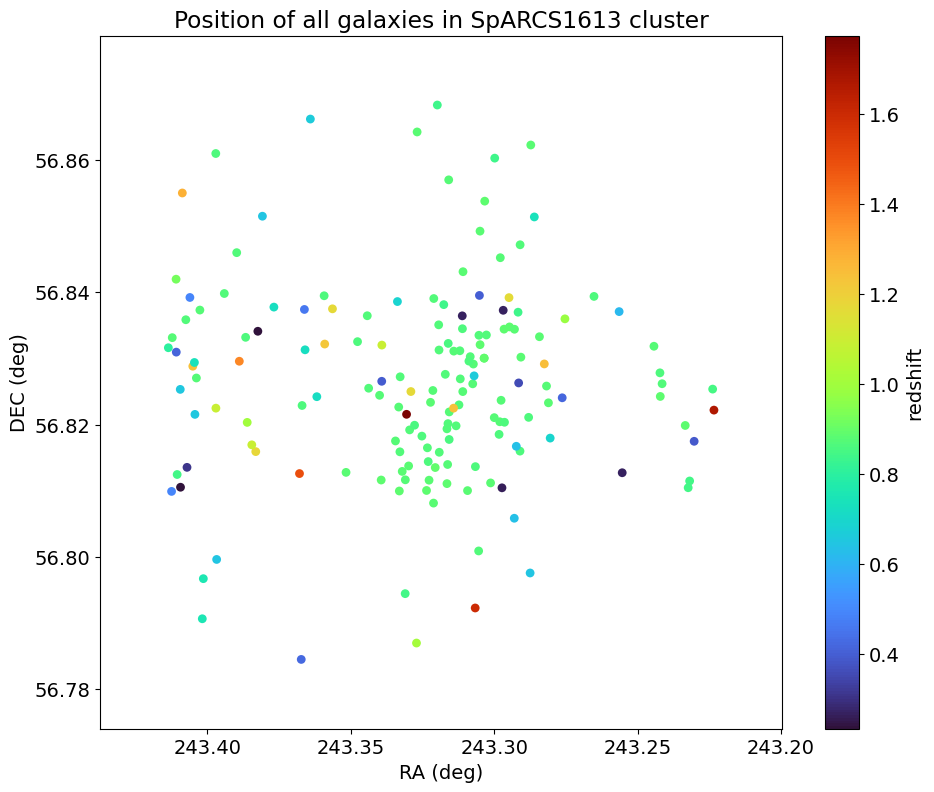

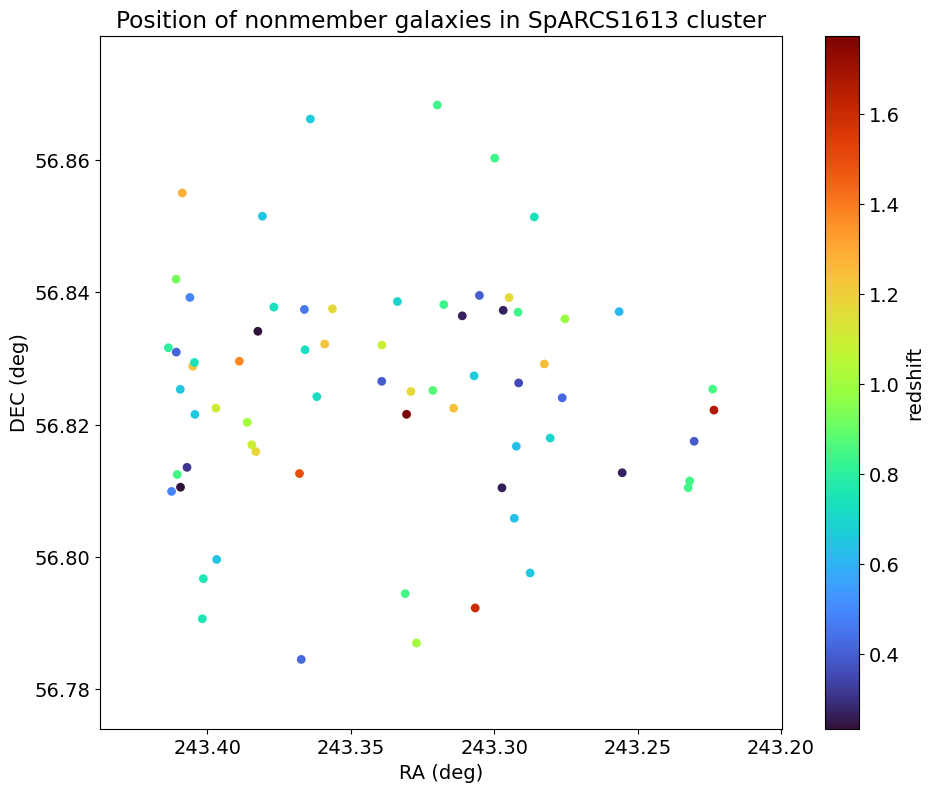

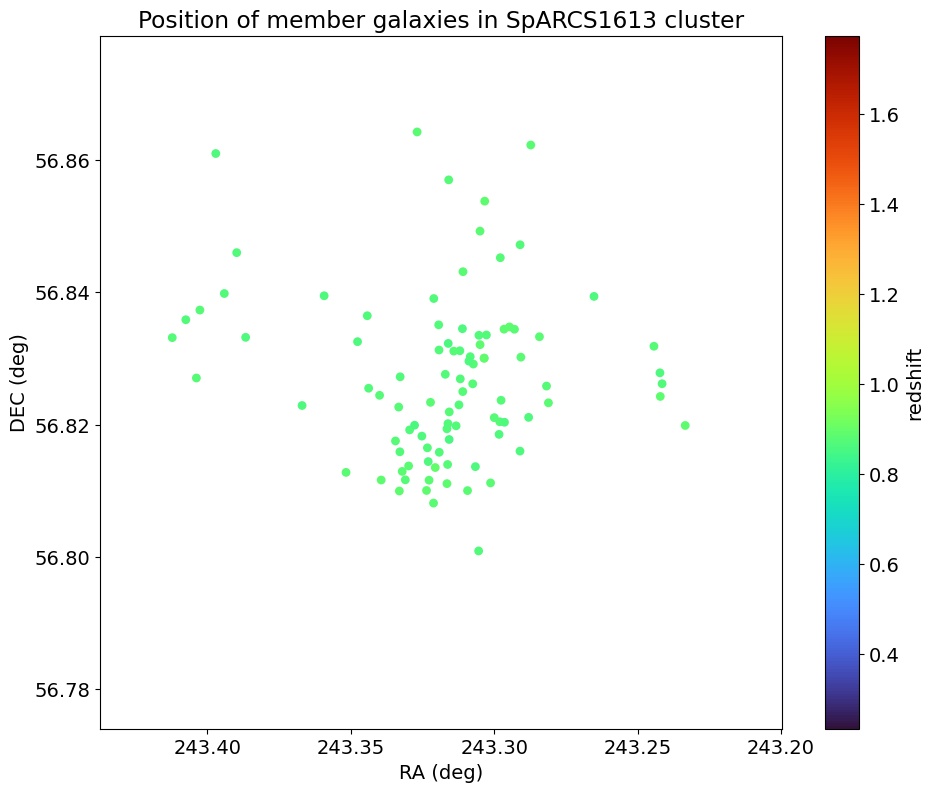

In [13]:
cluster_galaxies(index_num,selection,clusters_table,redshift_table)

We can see the redshift of all galaxies vary in the first plot. Then, by separating the galaxies to members and nonmembers, we can see galaxies identified as members all have a similar redshift, which makes sense if they are part of the same cluster. However, galaxies of the similar redshift values are also found in the nonmembers plot, so redshift is not the only variable considered when making the decision.

<a class="anchor" id="GG4"></a>
# Choose an image of the selected cluster
Now that we know what the positions of the galaxies are in the selected cluster, let's compare the previous plots to a processed image. First, return all available image urls by calling the SIA service. Specific types of filters and images can be excluded, and in this case, 'mask' images are excluded.

In [14]:
def choose_image(index_num, name, clusters_table, redshift_table):
    """
    Return image urls of varying origins and filters in selected cluster excluding masks in a pandas dataframe.

    Parameters
    ----------
    index_num : int
    Index of selected cluster
    
    name : string
    Name of selected cluster
    
    clusters_table : pandas dataframe
    Data table for all clusters
    
    redshift_table : pandas dataframe
    Data table for all galaxies

    Returns
    -------
    row : pandas dataframe
    Data table for image urls of selected cluster
    
    copy_cluster : pandas dataframe
    Data table pulled from clusters_table with only the selected cluster
    """
    # select clusters pandas dataframe for selected cluster index
    copy_cluster = clusters_table.iloc[index_num] 
    fov = 1 # degrees (= 12 arcmin)
    ra, dec = copy_cluster.ra_best, copy_cluster.dec_best
    print("%s cluster RA = %f, DEC = %f" %(name,ra,dec))
    imgTable = svc.search((ra,dec), (fov, fov), verbosity=2).to_table().to_pandas()
    print("All images in area")
    display_html(imgTable.head())
    
    #split name by its letter [0] and numbers [1] and match case-insensitive url
    split_name = re.split('(\d+)',name)
    row = pd.DataFrame()
    for i in range(len(imgTable.access_url)):
        
        if split_name[0].lower() in imgTable.access_url[i].lower() \
        and split_name[1] in imgTable.access_url[i] \
        and 'mask' not in imgTable.access_url[i].lower():
            
            data = (imgTable.iloc[[i],:])
            row = pd.concat((row,data))
            
    print("Images of selected cluster excluding masks")
    display_html(row.head())
    
    #print all available urls in row dataframe
    for i in range(np.nanmax(row.index)+1): 
        if i not in row.index:
            continue
        else:
            print(i,row.access_url[i])
    return (row, copy_cluster)

In [15]:
row, copy_cluster=choose_image(index_num, selection, clusters_table, redshift_table)

SpARCS1613 cluster RA = 63.311000, DEC = 56.825000
All images in area


,assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic


Images of selected cluster excluding masks


""


ValueError: zero-size array to reduction operation maximum which has no identity

The user can either pick a url from the list above, or they can automatically retrieve a Hubble Space Telescope image if it is available. If there is no Hubble image, the automatic option will return the first url in the pandas dataframe.

In [14]:
def return_image_numpy(row, index):
    """
    Returns the image pixel numpy array, image coordinate system, and Hubble indicator from the image url and .fits file.

    Parameters
    ----------
    row : pandas dataframe
    Data table for image urls of selected cluster
    
    index : int
    Index argument passed as Hubble image index, first image available, or user_pick_index

    Returns
    -------
    image : numpy array of float
    Pixel data for the image
    
    wcs : class astropy.wcs.wcs.WCS
    Used as an argument for transforming the position into World Coordinates System
    
    Hubble : int
    Used to specify image reshaping to fit entire plot
    """
    url = row['access_url'][index]
    filename = download_file(url,cache=True,show_progress=False,timeout=120)
    hdu = fits.open(filename)[0]
    image = hdu.data
    wcs = WCS(hdu.header)
    print("index = %i, url = %s" %(index, row.access_url[index]))
    if 'HST' in row.access_url[index]:
        Hubble = 1
    else:
        Hubble = 0
        
    return (image, wcs, Hubble)

In [16]:
def pick_url(row, user_pick_index=None):
    """
    Automatically prioritizes a Hubble image url in table and returns the index, url, and Hubble = 1 indicator (for plotting purposes).
    If a Hubble image is not found, return the first available index, url, and Hubble = 0 indicator. User can input an index for manual picking.

    Parameters
    ----------
    row : pandas dataframe
    Data table for image urls of selected cluster
    
    user_pick_index : int
    User's choice of image from the list of available indices above

    Returns
    -------
    image : numpy array of float
    Pixel data for the image
    
    wcs : class astropy.wcs.wcs.WCS
    Used as an argument for transforming the position into World Coordinates System
    
    Hubble : int
    Used to specify image reshaping to fit entire plot
    """
    wcs = None
    Hubble = 0
    #pick image
    if user_pick_index==None:
        for j in range(0, np.nanmax(row.index)+1):
            if j not in row.index:
                continue

            elif 'F140W' in row.access_url[j] and 'sci' in row.access_url[j]: #prioritize hubble image
                image, wcs, Hubble = return_image_numpy(row,j)

            elif j==(np.nanmax(row.index)) and wcs==None: #else choose first available matched image
                image, wcs, Hubble = return_image_numpy(row,np.nanmin(row.index))
    else:
        if user_pick_index not in row.index:
            print("Index not found in image table; please select from these options:", row.index)
            return 0, 0, 0

        image, wcs, Hubble = return_image_numpy(row,user_pick_index)
    
    return (image, wcs, Hubble)

In [17]:
image, wcs, Hubble=pick_url(row)

NameError: name 'row' is not defined

<a class="anchor" id="GG5"></a>
# Display image of selected cluster
Retrieve a processed image of the cluster of interest based on the position (RA, DEC), and the expected picture should include the galaxies in the cluster field of view. We will highlight their expected positions with overlays. When plotting processed images, each image has a different pixel contrast range and composition indicated by the print out statement. The contrast (vbot, vtop) for the Hubble image and the first available index image has been determined, but plotting any other indices will rely on the user to play around with the contrast parameters.

In [17]:
def display_image(image, wcs, Hubble, name, copy_cluster, redshift_table):
    """
    Plots the selected processed image and outlines the galaxies by nonmember or member color coding.

    Parameters
    ----------
    image : numpy array of float
    Pixel data for the image
    
    wcs : class astropy.wcs.wcs.WCS
    Used as an argument for transforming the position into World Coordinates System
    
    Hubble : int
    Used to specify image reshaping to fit entire plot
    
    name : string
    Name of the selected cluster
    
    copy_cluster : pandas dataframe
    Data table pulled from clusters_table with only the selected cluster
    
    redshift_table : pandas dataframe
    Data table for all galaxies

    Returns
    -------
    None
    """
    print("image coloring contrast min = %f, max = %f, median = %f" %(np.nanmin(image),np.nanmax(image),np.median(image)))
    
    #display image
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(projection=wcs, label='overlays')
    vrange = np.nanmax(image)-np.nanmin(image)
    vbot = np.nanmin(image)+.00085*vrange #change percentage as needed
    vtop = np.nanmin(image)+.05*vrange #change percentage as needed
    if Hubble==1:
        vbot = np.nanmin(image)+0.00012*vrange #change percentage as needed
        vtop = np.nanmin(image)+0.0005*vrange #change percentage as needed
    ax.imshow(np.arcsinh(image),origin='lower',cmap='bone',vmin=np.arcsinh(vbot),vmax=np.arcsinh(vtop))
    ax.set_title(copy_cluster.cluster)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('d.ddd')
    lat.set_major_formatter('d.ddd')

    ax.grid(color='white', ls='solid')
    
    #overlay memeber and nonmember circles
    quote_name = f'"{name}"'
    requirement = 'cluster==%s'%quote_name
    rax, decy, mem = redshift_table.query(requirement)[['ra','dec','member']].values.T
    ax.scatter(rax,decy,transform=ax.get_transform('world'),s=100,fc='none',edgecolors='magenta',label='nonmember') 
    ax.scatter(rax[mem==1],decy[mem==1],transform=ax.get_transform('world'),s=100,fc='none',edgecolors='cyan',label='member')
    if Hubble==1:
        plt.ylim(0, image.shape[0])
        plt.xlim(0, image.shape[1])
    plt.legend(loc="upper left")

image coloring contrast min = -0.181851, max = 801.536926, median = 0.000000


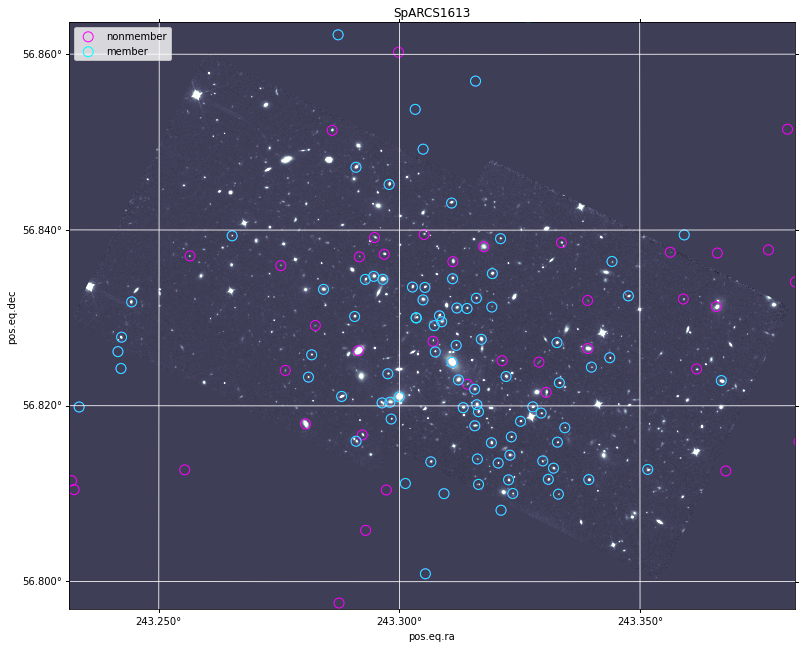

In [18]:
display_image(image, wcs, Hubble, selection, copy_cluster, redshift_table)

As expected, the processed image aligns with the positions outlined by the database. Some galaxies appear faint, while there are two bright galaxies close to the central region. For galaxies within the image footprint, the overlay circles mark which of them are members (in cyan) or nonmembers (in magenta).

Overall, to recap, the cluster and galaxy dataset tables were read from GOGREEN DR1. Then, we selected a specific cluster with the highest dynamical mass based on the highest velocity dispersion as a case example. One way to visualize the cluster membership status was to plot the nonmember and member galaxies separately, color-coded by redshift. The member galaxies all have similar redshifts by definition and are assumed to be in a gravitationally bound cluster (e.g., moving together as a group away from us as the universe is expanding). Finally, we utilized the SIA service to search for the processed image urls, and the default Hubble image shows that we are able to match the dataset to the images correctly.

<a class="anchor" id="GG6"></a>
# References

[Wikipedia contributors.](https://en.wikipedia.org/wiki/Mollweide_projection) "Mollweide projection." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 23 Feb. 2022. Web.

[Wikipedia contributors.](https://en.wikipedia.org/wiki/Velocity_dispersion) "Velocity dispersion." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 25 Jun. 2022. Web.

Notebook [GOGREEN Data Release 1 data access at Astro Data Lab.](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/1_GOGREENDr1DataAccessAtDataLab.ipynb)

Notebook [GOGREEN DR1 at Data Lab - Simple Image Access (SIA).](https://github.com/astro-datalab/notebooks-latest/blob/master/03_ScienceExamples/GOGREEN_GalaxiesInRichEnvironments/2_GOGREENDr1SIA.ipynb)

[Balogh et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500..358B/abstract) "The GOGREEN and GCLASS surveys: first data release." MNRAS 500, 358